<a href="https://colab.research.google.com/github/nadavschwalb/image_processing/blob/main/Lab6_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Lab 6 - JPEG Compressionend </center></h1>

## Goal: Introduction of principles of the JPEG baseline coding system.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd '/content/drive/My Drive/image_processing/Lab_6'
%ls
import os
path = os.getcwd() 
print('path: ' + path)

/content/drive/My Drive/image_processing/Lab_6
 Amsterdam.jpg         compressed_q_4       'Copy of Lab6_v2.ipynb'
 bird.bmp              compressed_q_4.jpg    fresh_prince.png
 compressed_q_10       compressed_q_60       Lab_6_preliminary.ipynb
 compressed_q_10.jpg   compressed_q_60.jpg   new_year.bmp
path: /content/drive/My Drive/image_processing/Lab_6


Import the necessary libraries:

In [3]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform,io,util,img_as_ubyte
import cv2
from skimage import restoration
import sys
import math
from PIL import Image
from scipy import fftpack

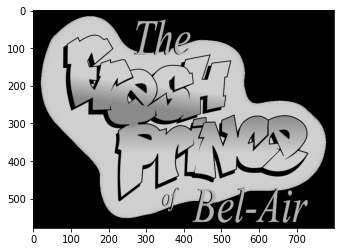

In [4]:
fresh_img = plt.imread('fresh_prince.png')

fresh_img = cv2.cvtColor(fresh_img,cv2.COLOR_RGB2GRAY)
plt.imshow(fresh_img, cmap = 'gray')
plt.show()

# 1. Helper Functions

In this section you will implement several helper functions which will be used in your implementation of JPEG compression and decompression. 

The functions ***quantize*** and ***dequantize*** are given:



In [5]:
def load_quantization_table(quality,block_size):
    q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]])* quality   # JPEG normalizing array and zig-zag reordering
    if (block_size != 8):
        q = transform.resize(q, (block_size, block_size), preserve_range=True)
    return q

def quantize(block, quality,block_size):
    q = load_quantization_table(quality,block_size)
    return np.array((block / q).round().astype(np.int32))

def dequantize(block, quality,block_size):
    q = load_quantization_table(quality,block_size)
    return block * q

1.   Complete the funcion ***zigzag(M,N)*** written in the preliminary report:

In [6]:
def zigzag(M,N):
  ## Your code here ##
  zigzag_order = [[] for i in range(M+N-1)]
  for i in range(M):
    for j in range(N):
      diagonal_num = i+j
      if diagonal_num%2 == 0:
        zigzag_order[diagonal_num].append(i*N + j) # even row up
      else:
        zigzag_order[diagonal_num].insert(0,i*N + j) #odd row down
        
  result = []
  for diag in zigzag_order:
    for j in diag:
      result.append(j)
  return np.array(result)

2.   Implement ***block_to_zigzag(block, order)***

This function transforms a *block_size* x *block_size* block of your image to a 1D array ordered according to the list of indices given in *order*. 

Hint: Use block.flatten()

3.   Implement ***zigzag_to_block(zigzag, order)***

This function performs the inverse operation. Given a 1D array ordered according to the list of indices given in *order*, it transforms it to a **square** block with its elements in their original location.


In [7]:
def block_to_zigzag(block:np.ndarray,order:list):
  flattened_block = block.flatten()
  zigzag = np.array([flattened_block[i] for i in order]).astype('int32')
  return zigzag

def zigzag_to_block(zigzag,order):

  N = int(np.sqrt(order.shape[0]))
  block = np.empty((N,N))
  flattened_block = np.empty(zigzag.shape)
  for i,j in enumerate(order):
    flattened_block[j] = zigzag[i]
  block = np.resize(flattened_block,(N,N)).astype('int32')
  return block

In [8]:
#test
block = np.array([[1, 2, 3],\
                  [4, 5, 6],\
                  [10,11,12]])
order = zigzag(3,3)
zigzag_res = block_to_zigzag(block,order)
print(f"order: {order}")
print(f"zigzag: {zigzag_res}")
print(f"block:\n {zigzag_to_block(zigzag_res,order)}")

order: [0 3 1 2 4 6 7 5 8]
zigzag: [ 1  4  2  3  5 10 11  6 12]
block:
 [[ 1  2  3]
 [ 4  5  6]
 [10 11 12]]


4. Implement 2D DCT and IDCT.

Expand your 1D function ***my_dct*** to 2D. Here you may use ***fftpack.dct*** and ***fftpack.idct***.

In [9]:
def dct_2d(image):
  image = fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')
  return image

def idct_2d(image):
  image = fftpack.idct(fftpack.idct(image.T, norm='ortho').T, norm='ortho')
  image[image>127] =127
  image[image<-128] = -128
  return image

# 2. JPEG Compression and Decompression

1.   Load and show the image of your choice (grayscale). Covert it to uint32.



Image shape: (320, 320), Image data type: uint32


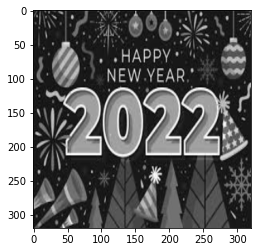

In [10]:
NewYear_img = plt.imread('new_year.bmp')

NewYear_img = cv2.cvtColor(NewYear_img,cv2.COLOR_RGB2GRAY)
NewYear_img = cv2.resize(NewYear_img, (320,320), interpolation=cv2.INTER_LINEAR)
NewYear_img = NewYear_img.astype('uint32')
print ("Image shape: {}, Image data type: {}".format(NewYear_img.shape,NewYear_img.dtype))
plt.imshow(NewYear_img, cmap = 'gray')
plt.show()

2.   Complete the missing code in the following ***im2jpeg*** implementation of JPEG compression and decompression.



In [11]:
# im2jpeg Compresses an image using a JPEG approximation.
# im2jpeg(img,block_size, quality) compresses image based on block_size x block_size DCT transforms and coefficient quantization.
# Input quality determines the amount of information that is lost and compression achieved. 

def im2jpeg(img, block_size=8, quality=1):
    if not isinstance(img, np.ndarray) or img.dtype != np.uint32: 
        print("The input must be a UINT32 image.")
        return
    rows, cols = img.shape[0], img.shape[1]
    # block size: (block_size x block_size)
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of {}".format(block_size)))

    # End-Of-Block (EOB) symbol
    eob = 256
    jpeg_list = list()
    
    # find the zigzag order
    order = zigzag(block_size, block_size)

    # loop over image blocks
    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):
                # Code the following steps
                # 1. extract a block of size block_size x block_size and center the data range on zero: [0, 255] --> [-128, 127]:
                block = (img[i:i+block_size, j:j+block_size] - 128).astype(np.int32)


                # 2. perform dct to the block:
                block_dct = dct_2d(block)

                # 3. quantize your dct block using given quality factor:
                block_dct_quantize = quantize(block_dct,quality,block_size)
                # 4. reorder in a zigzag pattern
                zigzaged_block = block_to_zigzag(block_dct_quantize,order)

                # 5. omit trailing zeros in reordered block
                zigzaged_block_trimmed = np.trim_zeros(zigzaged_block)
                
                # 6. add eob in the end of the block
                zigzaged_block_trimmed = np.append(zigzaged_block_trimmed,np.array(eob))
                
                # 7. append the dct block to the list
                jpeg_list.append(zigzaged_block_trimmed)
                
    #convert the list to array
    jpeg_array = np.concatenate(jpeg_list,axis=None)
    return jpeg_array



# jpeg2im Decodes an IM2JPEG compressed image.
# jpeg2im(jpeg_img,block_size,quality) decodes compressed image jpeg_img, generating reconstructed approximation X. 
# jpeg_img is generated by im2jpeg.

def jpeg2im(jpeg_img, block_size=8, quality = 1):
    eob = 256
    
    # find the zigzag order
    order = zigzag(block_size, block_size)

    # find the End-Of-Block (EOB) symbols
    ends_of_blocks = np.where(jpeg_img == eob)[0]
    num_of_block = ends_of_blocks.shape[0]
    
    # assuming that the image height and width are equal
    image_side = int(math.sqrt(num_of_block)) * block_size
    blocks_per_line = image_side // block_size
    
    # create new empty image: 
    npmat = np.empty((image_side, image_side), dtype=np.int32)
    
    start = 0
    for block_index, end in enumerate(ends_of_blocks):
        # 1. initialize new block
        zz_list = np.zeros(block_size*block_size)

        # 2. assign values from jpeg_img into beginning of zz_list
        zz_list[:end-start] = jpeg_img[start:end]

        # 3. convert zz_list back into block
        quant_matrix = zigzag_to_block(zz_list, order)

        # 4. dequnatize
        dct_matrix = dequantize(quant_matrix,quality,block_size)

        # 5. perform idct to block
        block = idct_2d(dct_matrix)

        # find the place in the image to put the block
        i = (block_index // blocks_per_line * block_size) 
        j = (block_index % blocks_per_line * block_size)
        npmat[i:i+block_size, j:j+block_size] = block + 128
        start = end + 1
    
    return npmat
    

3. Compress your image using the JPEG compression algorithm calling ***im2jpeg*** and restore the image from its compressed form calling ***jpeg2im***.   
    * Present the original and restored images.
    * Print the number of elements in the original and compressed images. 
    * Explain why blocking effects can be seen in the restored image.   
    * Show the blocking effects by zooming in for intresting parts of the image. 

original image size: 102400
compressed image size: 36385


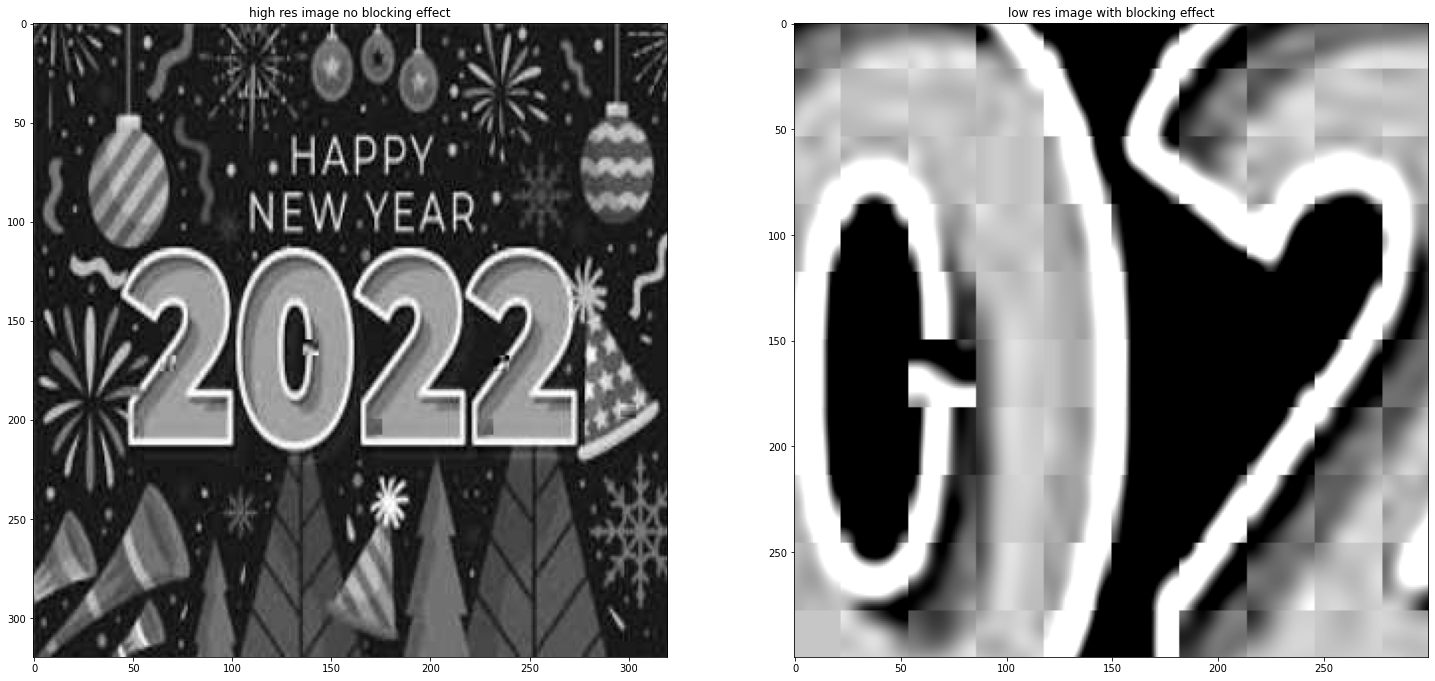

In [12]:
compressed_img_no_blocking = im2jpeg(NewYear_img,block_size=8,quality=1)
decompressed_img_no_blocking = jpeg2im(compressed_img_no_blocking,block_size=8,quality=1)
compressed_img_blocking = im2jpeg(NewYear_img,block_size=64,quality=10)
decompressed_img_blocking = jpeg2im(compressed_img_no_blocking,block_size=32,quality=10)
print(f"original image size: {NewYear_img.size}")
print(f"compressed image size: {compressed_img_no_blocking.size}")
fig = plt.figure(figsize=(25,25))
plt.subplot(121)
plt.title('high res image no blocking effect')
plt.imshow(decompressed_img_no_blocking,cmap='gray')
plt.subplot(122)
plt.title('low res image with blocking effect')
center = int(decompressed_img_blocking.shape[0]/2)
zoom = 150
plt.imshow(decompressed_img_blocking[center-zoom:center+zoom,center-zoom:center+zoom],cmap='gray')
plt.show()

in a low quality compression with large blocks we can get a substantial blocking effect this is because each block is transformed and is passed through a LPF seperatly, then it is converted back seperatly.
this means that for each block we loose information and the restoration is destorted. however when the block size is larger the effect is more noticable and when the quality value is higher (and the quailty itself is lower) more values are quantized out (i.e the LPF has a lower frequency) and the decompressed blocks have more distortion.

this is the meaning of lossy compression, we loss information when compressing

# 3. Analysis

1. Plot the graph of compression ratio (Y axis) versus a “quality” parameter of *im2jpeg* (X axis). Use the supplied function *imratio*.  

Use the following quality parameters: 1,2,4,6,8,10,12,16,20,25

__Remark:__ the “quality” parameter defines the quality of compression and not the quality of restoration. It is defined to be greater or equal to 1. The “quality” equal to 1 corresponds to the best quality of restoration and the worst quality of compression.


In [13]:
def imratio(original_img1,compressed_img2):
    return float(compressed_img2.nbytes)/original_img1.nbytes

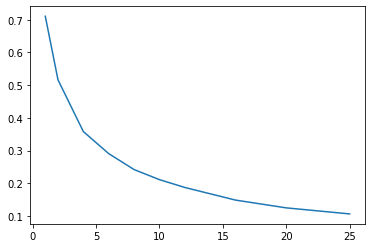

In [14]:
qualitys = [1,2,4,6,8,10,12,16,20,25]
compression_ratios = [imratio(NewYear_img,im2jpeg(NewYear_img,quality=quality)) for quality in qualitys]
plt.plot(qualitys,compression_ratios)

we see a 1/x relationship as this is the relationship between the number of quantization groups and quality. the larger quality is, the larger the values in the quantization matrix are and the smaller the range of values in the quantized image.
this will result in more zeros after the dct that we then trim resulting in the compression

therefore the higher the quality value is the more compression meaning a lower compression ration.

2. The Root Mean Square (RMS) error of restoration is defined in the following way:  
\begin{equation*}
RMS = \left( \frac{1}{MN}  \sum_{k=0}^{M-1} \sum_{k=0}^{N-1} (\hat{f}(i,j)-f(i,j))^2 \right)^{0.5}
\end{equation*}

    where $f(i, j)$ is the original image, $\hat{f}(i,j)$ is the restored image and $M \times N$ is the size of both images.    
    
    Plot the graph of Root Mean Square (RMS) Error of restoration (Y axis) versus compression ratio (X axis). This graph is called Rate-Distortion curve.  
    
__Hint__: you can use the supplied functions *imratio*.



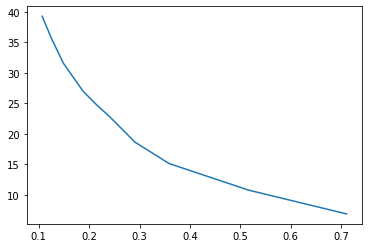

In [15]:
def calc_rms(original, restored):
  M = original.shape[0]
  N = original.shape[1]
  rms = np.sqrt((1/(M*N))*np.sum((np.square(original-restored))))
  return rms

rms = [calc_rms(NewYear_img,jpeg2im(im2jpeg(NewYear_img,quality=quality),quality=quality)) for quality in qualitys]
plt.plot(compression_ratios,rms)

as the compression ratio gets smaller (the compressed image is smaller in size) the RMS value grows, this is because the diffrence between the original and compressed image is getting bigger

3.	Repeat question 2.3 for block sizes __4X4__ and __16X16__. 
    * Compare blocking effects for different block sizes.   
    * Compare the compression of the algorithm for different block sizes.   
    * What are the advantages and disadvantages of changing the block size? 

In [ ]:
compression_ratios_4x4 = [imratio(NewYear_img,im2jpeg(NewYear_img,block_size=4,quality=quality)) for quality in qualitys]
compression_ratios_16x16 = [imratio(NewYear_img,im2jpeg(NewYear_img,block_size=16,quality=quality)) for quality in qualitys]
rms_4x4 = [calc_rms(NewYear_img,jpeg2im(im2jpeg(NewYear_img,block_size=4,quality=quality),block_size=4,quality=quality)) for quality in qualitys]
rms_16x16 = [calc_rms(NewYear_img,jpeg2im(im2jpeg(NewYear_img,block_size=16,quality=quality),block_size=16,quality=quality)) for quality in qualitys]


In [ ]:
plt.subplot(121)
plt.title('block size comparison')
plt.plot(compression_ratios_4x4,rms_4x4)
plt.plot(compression_ratios_16x16,rms_16x16)
plt.legend(['4x4 block','16x16 block'])
plt.show()

we can see that at a lower commpression ratio the 4x4 blocks have a higher rms value since the LPF of quantization filters out move values overall. however when we use a higher compression ratio (higher fidelity commpression) the 4x4 block will give us better results since we have better resolution of the original image. to the extreme if the block size was 1 and quality was 1 we would just get the original image.

the traidoff is that processing 4x4 blocks is much more demanding, we timed (all be it a very underoptimized code) at around 15 seconds per image.



```
# This is formatted as code
```



4. Use the following python build in function for JPEG compression:
        result = Image.fromarray((img).astype(np.uint8))
        result.save(Compressed_File_Name,"JPEG",optimize=True,quality= Your_quality)
   * Compress your image by using this function.
   * Load and show the compressed image. 
   * Compare the saved compressed image size in memory vs. the origonal image size.
   * Plot the compressed imag with quality of: 4, 10, 60.
   
   
__Note__: The 'quality' parameter is different here from the 'quality' parameter that we used in this lab implementation.


In [ ]:
import os
qualities = [4,10,60]
plt.figure(figsize=(20,20))
print(f'original image\t\t\tsize:',os.path.getsize('new_year.bmp'))
plt.subplot(141)
plt.title('original image')
plt.imshow(NewYear_img,cmap='gray')
for i, quality in enumerate(qualities):
  result = Image.fromarray((NewYear_img).astype(np.uint8))
  result.save(f'compressed_q_{quality}.jpg',"JPEG",optimize=True,quality= quality)
  print(f'compressed with quality = {quality}\tsize:',os.path.getsize(f'compressed_q_{quality}.jpg'))
  compressed = plt.imread(f'compressed_q_{quality}.jpg')
  plt.subplot(142+i)
  plt.title(f'compressed with quality = {quality}')
  plt.imshow(compressed,cmap='gray')
plt.show()

Insert your answer here